## 7. Hypothesis Testing
Statistical hypothesis testing is a statistical technique that evaluates whether data support a particular hypothesis. In this notebook, we will again use <b>statsmodels</b> to implement some hypothesis tests. We again use the data on land value and distance to DC as before, assuming you have already read Notebook 6. (Moreover, this notebook assumes you have basic knowledge of hypothesis testing, and will not go into detail about the theory.)<br><br>
### 7.1. Hypothesis Test for a Population Mean
As an example of a simple hypothesis test, first we implement a method called <i>independent samples t-test</i> which evaluates whether a statistically significant difference in means exists between two independent groups. Specifically, we again use the land value data from Notebook 6 to test whether there is a significant difference between land values in Montgomery county and prince George's county.<br><br>
First, as before, we will load the data and display the land values for both. (To ensure the normality of the data, in this exercise we will log-transform the land value.)

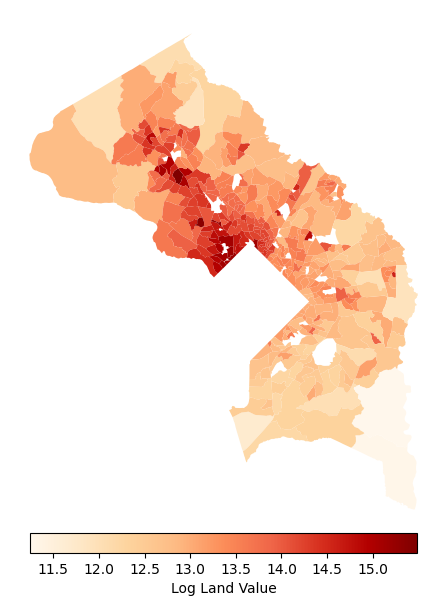

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

pd.options.mode.copy_on_write = True 

maryland = gpd.read_file('tl_2010_24_tract10/tl_2010_24_tract10.shp')
mg_pg = maryland.query("COUNTYFP10 in ['031', '033']")

# These two lines creating keys for merging the data 
mg_pg['tract'] = mg_pg['TRACTCE10'].astype(int)
mg_pg['county'] = mg_pg['STATEFP10'].astype(int)*1000 + mg_pg['COUNTYFP10'].astype(int)

# Load land price data
df_lv = pd.read_csv('land_value.csv')
# Take logarithm
df_lv['log_land_value'] = np.log(df_lv['land_value'])
# Merge the data
mg_pg = pd.merge(mg_pg, df_lv, on=['county', 'tract'], how='left')

# Load land price data
df_mi = pd.read_csv('mi_to_dc.csv')

# Merge the data
mg_pg = pd.merge(mg_pg, df_mi, on=['county', 'tract'], how='left')

# Show the map
mg_pg.plot(figsize=(10, 8), cmap='OrRd', linewidth=0.1, column='log_land_value',legend=True, legend_kwds={"label": "Log Land Value", "orientation": "horizontal", "shrink": 0.5, "pad": 0},)
plt.axis('off')
plt.show()

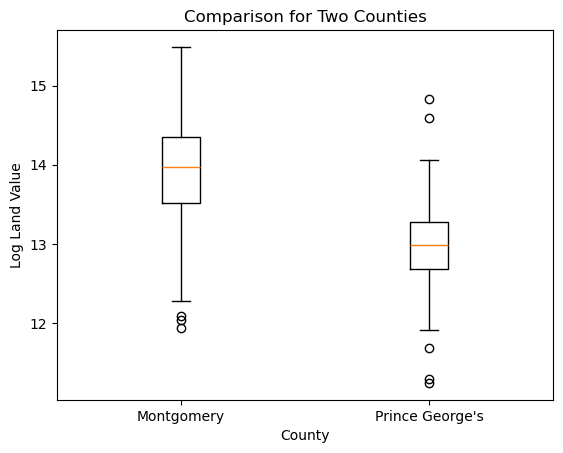

In [8]:
mg = mg_pg[mg_pg['county']==24031] # Select Montgomery County
pg = mg_pg[mg_pg['county']==24033] # Select Prince George's County

plt.boxplot([mg['log_land_value'].dropna(), pg['log_land_value'].dropna()],
             labels=['Montgomery', 'Prince George\'s'])

plt.title('Comparison for Two Counties')
plt.xlabel('County')
plt.ylabel('Log Land Value')
plt.show()

### 7.2 Two-sided Tests
The above figures seem to already support the hypothesis that there is a difference between the two counties, but here we confirm it in a formal statistical way. The null and alternative hypotheses for our test are as follows:<br><br>

<b>Null hypothesis</b>: The mean land prices for Montgomery county and Prince George's county are the same.<br>
<b>Alternative hypothesis</b>: The mean land prices for Montgomery county and Prince George's county are different.<br><br>

To perform the test for this hypothesis, theoretically speaking we need to compute the t-statistic for the difference in means using the following equation.
$$
t = \frac{\bar{x}_1-\bar{x}_2}{s\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}
$$
where $\bar{x}_i$, $n_i$, and $s$ denote the sample mean, the sample size, and the square root of the sample variance.<br><br>
With <b>statsmodels</b>, there is no need to manually calculate the above t-statistics, and the hypothesis tests are performed automatically. Specifically we use the function <b>sm.stats.ttest_ind()</b>. To perform the above test, simply input the two series (i.e., Montgomery and Prince George's county land value data) into this function. This function returns the t-statistic, p-value, and degrees of freedom.

In [10]:
import statsmodels.api as sm

t_stat, p_value, df = sm.stats.ttest_ind(mg['log_land_value'].dropna(), pg['log_land_value'].dropna())

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", df)

T-statistic: 16.28420878842597
P-value: 8.79337791676091e-46
Degrees of Freedom: 387.0


As shown in the results above, the t-value is very large and the p-value is very small. Since the null hypothesis is easily rejected even at the 1% significance level, we can conclude that "the means of the two counties are different" from this test.<br>
#### One-tailed Test
The above is the so-called two-tailed test, but now let's try a one-tailed test. The null and alternative hypotheses are slightly changed as follows:<br><br>
<b>Null hypothesis</b>: The mean land prices for Montgomery county and Prince George's county are the same.<br>
<b>Alternative hypothesis</b>: The mean land price for Montgomery county is higher than that for Prince George's county.<br><br>

If you specify the <b>alternative</b> parameter, <b>sm.stats.ttest_ind()</b> performs a one-tailed test while it does a two-tailed test by default. If you input `alternative='larger'`, the alternative hypothesis will be "the mean for the first group is larger than that for the second group." In our case, the code will be as follows:


In [12]:
t_stat, p_value, df = sm.stats.ttest_ind(mg['log_land_value'].dropna(), pg['log_land_value'].dropna(), alternative='larger')
# make sure the first input is the data of montgomery county

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", df)

T-statistic: 16.28420878842597
P-value: 4.396688958380455e-46
Degrees of Freedom: 387.0


Again, the t-value is very large and the p-value is very small. We can conclude that "the mean land price of Montgomery county is higher than that of Prince George's county" from this test.<br>
#### Welch Test
By the way, the independent two-sample test so far assumes that the variances of the two groups are equal. <b>sm.stats.ttest_ind()</b> can also perform the so-called Welch's t-test, which relaxes this assumption. The formula for the t-statistics is as follows, but of course you do not need to calculate this manually.
$$
t = \frac{\bar{x}_1-\bar{x}_2}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}
$$

To conduct Welch test, you specify the <b>usevar</b> parameter as `usevar='unequal'`.

In [16]:
t_stat, p_value, df = sm.stats.ttest_ind(mg['log_land_value'].dropna(), pg['log_land_value'].dropna(), usevar='unequal')
# make sure the first input is the data of montgomery county

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", df)

T-statistic: 16.21721598843669
P-value: 2.1628716759254577e-44
Degrees of Freedom: 345.9785068129458


The p-value continues to be very small, but it is slightly larger after accounting for the difference in the variance of the two counties.

### 7.3 Hypothesis Tests with a Regression Model
Next, let's implement hypothesis testing in regression analysis. Here we again use the model of land value and distance to DC used in Notebook 6. However, we extend the model a bit by adding the interaction term of `mi_to_dc` and Montgomery dummy as follows:
$$
\log (land\;value_i) = \alpha + \beta\times(mile\;to\;DC_i) + \theta\times(mile\;to\;DC_i)\times(Montgomery\;dummy_i) + \gamma\times (Montgomery\;dummy_i)+\epsilon_i
$$
This formulation allows for different slopes and intercepts for the two counties. Namely, the slope for Montgomery county is $(\beta+\theta)$, while that for Prince George's county is $\beta$. If $\theta$ is statistically significantly different from 0, we can conclude these two slopes are different. <br><br>
#### t-test with a Regression Model
First, we implement t-test, which is the most common and almost always done in regression analysis. As an example, consider testing whether the slope of `mi_to_dc` is the same in two counties. This can be tested by testing whether $\theta$, which is the coefficient of the cross term, is zero. Our hypotheses for this test are as follows:<br><br>
<b>Null hypothesis</b>: $\theta=0$ (Their slope are the same)<br>
<b>Alternative hypothesis</b>: $\theta\neq0$ (Their slope are different)<br><br>
We load the data and run regression as we did in Notebook 6. (Please see Notebook 6 for details.)

In [21]:
######## load and combine data ############

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

maryland = gpd.read_file('tl_2010_24_tract10/tl_2010_24_tract10.shp')
mg_pg = maryland.query("COUNTYFP10 in ['031', '033']")

# These two lines creating keys for merging the data 
mg_pg['tract'] = mg_pg['TRACTCE10'].astype(int)
mg_pg['county'] = mg_pg['STATEFP10'].astype(int)*1000 + mg_pg['COUNTYFP10'].astype(int)

# Load land price data
df_lv = pd.read_csv('land_value.csv')
# Take logarithm
df_lv['log_land_value'] = np.log(df_lv['land_value'])
# Merge the data
mg_pg = pd.merge(mg_pg, df_lv, on=['county', 'tract'], how='left')

# Load land price data
df_mi = pd.read_csv('mi_to_dc.csv')

# Merge the data
mg_pg = pd.merge(mg_pg, df_mi, on=['county', 'tract'], how='left')
mg_pg_w_dummy = pd.concat([mg_pg, pd.get_dummies(mg_pg['county'], dtype=float)], axis=1) # merge dummy df to the original df
mg_pg_w_dummy.rename(columns={24031: 'Montgomery'}, inplace=True) # Originally, 24031 is the name of the Montgomery dummy. Rename this to 'Montgomery' for readability of the code


######## regression ############

mg_pg_dropna = mg_pg_w_dummy[['log_land_value', 'mi_to_dc', 'Montgomery']].dropna()

# Create cross-term
mg_pg_dropna['mi_to_dc_Montgomery'] = mg_pg_dropna['mi_to_dc'] * mg_pg_dropna['Montgomery']

X = mg_pg_dropna[['mi_to_dc', 'mi_to_dc_Montgomery', 'Montgomery']] # select multiple columns for multivariate regression
y = mg_pg_dropna['log_land_value']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

One way to perform a t-test in a regression model is to simply display the summary table and check the t-values (or p-values).

In [23]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_land_value   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     140.2
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           2.17e-61
Time:                        16:57:34   Log-Likelihood:                -302.59
No. Observations:                 389   AIC:                             613.2
Df Residuals:                     385   BIC:                             629.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.1901    

The summary table above shows that the p-value of the coefficient of the intersection term between mi_to_dc and Montgomery dummy is 0.197, indicating that the null hypothesis $\theta=0$ cannot be rejected.<br><br>
Another way to perform a t-test on the regression coefficients is to use the <b>.t_test()</b> method of the model object. As an argument, enter the hypothesis you wish to test. Since we want to test whether the coefficient of `mi_to_dc_Montgomery` is zero, the code is as follows (Of course, the result remains the same):

In [26]:
model.t_test('mi_to_dc_Montgomery = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0151      0.012     -1.292      0.197      -0.038       0.008

Moreover, we can also set a null hypothesis other than "coefficient=0" by using the <b>.t_test()</b> method. For example, a test on the null hypothesis that the coefficient = 1 would be as follows:

In [29]:
model.t_test('mi_to_dc_Montgomery = 1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0151      0.012    -86.682      0.000      -0.038       0.008

As the above results show, the hypothesis that the coefficient of the cross term is 1 is easily rejected.<br><br>
As a side note, there is an F-test that is equivalent to the above t-test. (We will discuss F-test again for multiple hypotheses testing in the next section.) Remember that the F-test is a test to compare the RSS of constrained and unconstrained models. In the above example, the original model is the unconstrained model, and the model with $\theta = 0$ constraint imposed (i.e., the intersection term dropped) is the constrained model. First, this constrained model is estimated.

In [32]:
X = mg_pg_dropna[['mi_to_dc', 'Montgomery']] # drop the cross-term
X = sm.add_constant(X)

model_constrained = sm.OLS(y, X).fit()

The <b>.compare_f_test()</b> method on the unconstrained model runs an F-test taking the constrained model as an argument. It returns F-statistics, p-value, and the degree of freedom of the restriction.

In [34]:
f_stat, p_value, df = model.compare_f_test(model_constrained)

print("F-statistic:", f_stat)
print("P-value:", p_value)
print("Degrees of Freedom (restriction):", df)

F-statistic: 1.6699860523621743
P-value: 0.19703549627504882
Degrees of Freedom (restriction): 1.0


Again, the p-value is around 0.2 and therefore the hypothesis $\theta = 0$ cannot be rejected. Now let's confirm this F-test is equivalent to the original t-test. Recall that the following relationship exists between the F-statistic and the t-statistic for a single hypothesis.
$$
F = t^2
$$
Let's calculate the square of the t-value and compare it with the F-statistics. The <b>.t-test()</b> method introduced earlier returns the result of the test as an object. In the following code, it is stored in a variable named `t_result`. The t-value and p-value of the test result can be accessed with the attributes <b>.tvalue</b> and <b>.pvalue</b>.

In [36]:
t_result = model.t_test('mi_to_dc_Montgomery = 0')
print(f't-statistic: {t_result.tvalue[0][0]}')
print(f't-statistic squared: {np.square(t_result.tvalue[0][0])}')
print(f'p-value (t-value): {t_result.pvalue}')
print('')
print(f"F-statistic: {f_stat}")
print(f"p-value (F-test): {p_value}")

t-statistic: -1.2922794018177401
t-statistic squared: 1.6699860523624164
p-value (t-value): 0.19703549627502703

F-statistic: 1.6699860523621743
p-value (F-test): 0.19703549627504882


As the above results show, $F=t^2$ holds and the p-values for both tests are exactly the same. We have confirmed the equivalence of the t- and F-tests.

#### F-test with a Regression Model
Next, let's try an F-test on our model. Recall that F-test can be used to test hypotheses about multiple coefficients. In the previous example, we considered whether the slopes of `mi_to_dc` differ in the two counties. In this F-test example, in addition to the slope, we consider whether the intercepts also differ. Remember our model is this:
$$
\log (land\;value_i) = \alpha + \beta\times(mile\;to\;DC_i) + \theta\times(mile\;to\;DC_i)\times(Montgomery\;dummy_i) + \gamma\times (Montgomery\;dummy_i)+\epsilon_i
$$
In other words, for Montgomery county, the regression equation is as follows:
$$
\log (land\;value_i) = (\alpha+\gamma) + (\beta+\theta)\times(mile\;to\;DC_i) +\epsilon_i
$$
For Prince George's county, 
$$
\log (land\;value_i) = \alpha + \beta\times(mile\;to\;DC_i) +\epsilon_i
$$
This means the intercept and slope for Montgomery county can be different from those for Prince George's county by $\gamma$ and $\theta$. If both parameters are 0, their equations are identical. To test the statistical significance of these parameters at once, our hypothesis for the F-test will be as follows:
<br><br>
<b>Null hypothesis</b>: $\theta=0$ and $\gamma=0$ (Both the slopes and the intercepts are the same for the two counties)<br>
<b>Alternative hypothesis</b>: $\theta\neq0$ or $\gamma\neq0$ (The slopes and/or the intercepts are different.)<br><br>
Recall that for the F-test we estimate unconstrained and constrained models and compute the F-statistics. The unconstrained model in our exercise (i.e., the model based on the alternative hypothesis) is the first model written above. On the other hand, a constrained model (i.e., a model based on the null hypothesis) is as follows:
$$
\log (land\;value_i) = \alpha + \beta\times(mile\;to\;DC_i) +\epsilon_i
$$
Let's estimate both models.

In [39]:
######## load and combine data ############

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.options.mode.copy_on_write = True 

maryland = gpd.read_file('tl_2010_24_tract10/tl_2010_24_tract10.shp')
mg_pg = maryland.query("COUNTYFP10 in ['031', '033']")

# These two lines creating keys for merging the data 
mg_pg['tract'] = mg_pg['TRACTCE10'].astype(int)
mg_pg['county'] = mg_pg['STATEFP10'].astype(int)*1000 + mg_pg['COUNTYFP10'].astype(int)

# Load land price data
df_lv = pd.read_csv('land_value.csv')
# Take logarithm
df_lv['log_land_value'] = np.log(df_lv['land_value'])
# Merge the data
mg_pg = pd.merge(mg_pg, df_lv, on=['county', 'tract'], how='left')

# Load land price data
df_mi = pd.read_csv('mi_to_dc.csv')

# Merge the data
mg_pg = pd.merge(mg_pg, df_mi, on=['county', 'tract'], how='left')
mg_pg_w_dummy = pd.concat([mg_pg, pd.get_dummies(mg_pg['county'], dtype=float)], axis=1) # merge dummy df to the original df
mg_pg_w_dummy.rename(columns={24031: 'Montgomery'}, inplace=True) # Originally, 24031 is the name of the Montgomery dummy. Rename this to 'Montgomery' for readability of the code


######## load data ############

mg_pg_dropna = mg_pg_w_dummy[['log_land_value', 'mi_to_dc', 'Montgomery']].dropna()

# Estimate unconstrained model

# Create cross-term
mg_pg_dropna['mi_to_dc_Montgomery'] = mg_pg_dropna['mi_to_dc'] * mg_pg_dropna['Montgomery']

X = mg_pg_dropna[['mi_to_dc', 'mi_to_dc_Montgomery', 'Montgomery']] # select multiple columns for multivariate regression
y = mg_pg_dropna['log_land_value']

X = sm.add_constant(X)

model_unconstrained = sm.OLS(y, X).fit()


# Estimate constrained model

X = mg_pg_dropna['mi_to_dc'] # select multiple columns for multivariate regression
y = mg_pg_dropna['log_land_value']

X = sm.add_constant(X)

model_constrained = sm.OLS(y, X).fit()

We do the F-test by running the <b>.compare_f_test()</b> method on the unconstrained model entering the constrained model as an argument. This method returns f-value, p-value, and degree of freedom of the restriction. The code will be as follows:

In [44]:
f_stat, p_value, df = model_unconstrained.compare_f_test(model_constrained)

print("F-statistic:", f_stat)
print("P-value:", p_value)
print("Degrees of Freedom (restriction):", df)

F-statistic: 205.46921736921362
P-value: 1.913776294691185e-61
Degrees of Freedom (restriction): 2.0


As we can see above, the p-value is extremely small meaning the null hypothesis is easily rejected.

#### Test for Heteroskedasticity (White's Test)
Recall that heteroskedasticity refers to a condition in which the variance of the error term is not the same for all observed values. It is important to check for the presence of heteroskedasticity, as it will bias the standard error estimates.<br><br>
In this exercise, we implement the <i>White's test</i>. The procedure for this test is relatively simple. The first step is to estimate a regression model. The next step is to estimate another model with the original model's residuals (squared) as the dependent variable and the same independent variables as the original model. Finally, test that all coefficients of the second model are zero. If this hypothesis is rejected, it means that there is heteroskedasticity because the variance depends on one or more of the independent variables.<br><br>
Let us first estimate our regression model.

In [47]:
####### Just a repetition ########

######## load and combine data ############

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.options.mode.copy_on_write = True 

maryland = gpd.read_file('tl_2010_24_tract10/tl_2010_24_tract10.shp')
mg_pg = maryland.query("COUNTYFP10 in ['031', '033']")

# These two lines creating keys for merging the data 
mg_pg['tract'] = mg_pg['TRACTCE10'].astype(int)
mg_pg['county'] = mg_pg['STATEFP10'].astype(int)*1000 + mg_pg['COUNTYFP10'].astype(int)

# Load land price data
df_lv = pd.read_csv('land_value.csv')
# Take logarithm
df_lv['log_land_value'] = np.log(df_lv['land_value'])
# Merge the data
mg_pg = pd.merge(mg_pg, df_lv, on=['county', 'tract'], how='left')

# Load land price data
df_mi = pd.read_csv('mi_to_dc.csv')

# Merge the data
mg_pg = pd.merge(mg_pg, df_mi, on=['county', 'tract'], how='left')
mg_pg_w_dummy = pd.concat([mg_pg, pd.get_dummies(mg_pg['county'], dtype=float)], axis=1) # merge dummy df to the original df
mg_pg_w_dummy.rename(columns={24031: 'Montgomery'}, inplace=True) # Originally, 24031 is the name of the Montgomery dummy. Rename this to 'Montgomery' for readability of the code


######## load data ############

mg_pg_dropna = mg_pg_w_dummy[['log_land_value', 'mi_to_dc', 'Montgomery']].dropna()

# Create cross-term
mg_pg_dropna['mi_to_dc_Montgomery'] = mg_pg_dropna['mi_to_dc'] * mg_pg_dropna['Montgomery']

X = mg_pg_dropna[['mi_to_dc', 'mi_to_dc_Montgomery', 'Montgomery']] # select multiple columns for multivariate regression
y = mg_pg_dropna['log_land_value']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

The White's test can be done automatically using the function <b>het_white()</b> in <b>statsmodels.stats</b>. The first argument is the residuals of the original model and the second argument is the independent variable of the original model. This function returns the following four values: The Lagrange multiplier statistic, The p-value for the LM test, The F-static, the p-value for the F-test.

In [50]:
from statsmodels.stats.diagnostic import het_white
lm_stat, p_value_lm, f_stat, p_value_f = het_white(model.resid, X)

print('LM-statistic:', lm_stat)
print('P-value (LM):', p_value_lm)
print('F-statistic:', f_stat)
print('P-value (F):', p_value_f)


LM-statistic: 37.32257170391023
P-value (LM): 5.160629888653179e-07
F-statistic: 8.129350258193158
P-value (F): 2.6283720415448744e-07


The p-values for both LM- and F-test are extremely small meaning the null hypothesis (i.e. no heteroskedasticity) is rejected.<br><br>
Since the White test supports the existence of heteroscedasticity, we need to correct the standard errors of our model. To do this, specify the `cov_type=` parameter when calling the <b>.fit()</b> method to estimate the model. You can choose `HC0`, `HC1`, `HC2`, and `HC3` for the covariance type. The example below uses the original White estimate (`cov_type=HC0`).

In [56]:
model_robust = sm.OLS(y, X).fit(cov_type='HC0')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:         log_land_value   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     164.1
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.63e-68
Time:                        17:13:32   Log-Likelihood:                -302.59
No. Observations:                 389   AIC:                             613.2
Df Residuals:                     385   BIC:                             629.0
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.1901    

The results in the summary table above reflect robust standard errors.<br><br>
For comparison, let us also display the results for the non-robust standard error case.

In [59]:
model_nonrobust = sm.OLS(y, X).fit()
print(model_nonrobust.summary())

                            OLS Regression Results                            
Dep. Variable:         log_land_value   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     140.2
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           2.17e-61
Time:                        17:13:50   Log-Likelihood:                -302.59
No. Observations:                 389   AIC:                             613.2
Df Residuals:                     385   BIC:                             629.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.1901    

The results do not differ significantly, but we confirm that the standard error is larger when the robust standard errors HC0 is used.<br><br>
As a side note, we briefly explain the difference between the HC0, HC1, HC2, and HC3 (Please see an econometrics textbook for more details). For simplicity, consider a single regression model. The estimator will be expressed as $\hat{\beta} = \beta + \Sigma x_iu_i/\Sigma x_i^2$. The asymptotic variance of $\hat{\beta}$ can be expressed as $Var(\hat{\beta}|x) = \Sigma x_i^2Var(u_i|x_i)/(\Sigma x_i^2)^2$. If the error term is homoskedastic (i.e. $Var(u_i|x_i) = \sigma^2$), the variance is very simple: $Var(\hat{\beta}|x)=\Sigma x_i^2\sigma^2/(\Sigma x_i^2)^2=\sigma^2/\Sigma x_i^2$, and it is easy to estimate $\sigma^2$. However, if there is a heteroskedasticity, $Var(\hat{\beta}|x)$ is not constant and therefore we need to find a way to somehow estimate this object.<br><br>
In HC0, the numerator ($\Sigma x_i^2Var(u_i|x_i)$) is estimated as follows:
$$
\hat{\frac{1}{n}\Sigma x_i^2Var(u_i|x_i)} = \frac{1}{n}\Sigma x_i^2\hat{u_i}^2
$$
where $\hat{u_i}$ denotes estimated residuals. It's easy to interpret this formula because this estimator just replaces $Var(u_i|x_i)$ with the square of estimated residuals.<br><br>
HC1 just adjusts HC0 by a degree of freedom correction to improve the small sample property.
$$
HC1 = \frac{N}{N-K}HC0
$$
where $N$ is the sample size and $K$ is the number of coefficients.<br><br>
HC2 further adjusts regarding the <i>leverages</i> of each observation. The leverage of an observation in our single regression model is defined as follows:
$$
h_{ii} = \frac{x_i^2}{\Sigma x_i^2}
$$
This value reflects how far a single observation is distant from other observations. Since it is known that high-leverage observations tend to bias the HC standard errors, HC2 make an adjustment as follows:
$$
\hat{\frac{1}{n}\Sigma x_i^2Var(u_i|x_i)} = \frac{1}{n}\Sigma \frac{x_i^2\hat{u_i}^2}{1-h_{ii}}
$$
<br><br>
HC3 is quite similar to HC2, but it uses $1/(1-h_{ii})^2$ as weights instead of $1/(1-h_{ii})$.
$$
\hat{\frac{1}{n}\Sigma x_i^2Var(u_i|x_i)} = \frac{1}{n}\Sigma \frac{x_i^2\hat{u_i}^2}{(1-h_{ii})^2}
$$